In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from collections import deque
import random

In [2]:
class GridWorld:
    ## Initialise starting data
    def __init__(self, height=8, width=8):
        # Set information about the gridworld (default 8x8, but flexible now)
        self.height = height
        self.width = width
        self.grid = np.zeros((self.height, self.width)) - 1

        # Set random start location for the agent (middle row, random column)
        self.current_location = (self.height // 2, np.random.randint(0, self.width))

        # Set locations for the bomb and the gold
        # (keep them near the top, but ensure valid positions)
        self.bomb_location = (1, min(3, self.width - 1))
        self.gold_location = (0, min(3, self.width - 1))
        self.terminal_states = [self.bomb_location, self.gold_location]

        # Set grid rewards for special cells
        self.grid[self.bomb_location[0], self.bomb_location[1]] = -10
        self.grid[self.gold_location[0], self.gold_location[1]] = 10

        # Set available actions
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']

    def get_available_actions(self):
        return self.actions

    def agent_on_map(self):
        grid = np.zeros((self.height, self.width))
        grid[self.current_location[0], self.current_location[1]] = 1
        return grid

    def get_reward(self, new_location):
        return self.grid[new_location[0], new_location[1]]

    def make_step(self, action):
        last_location = self.current_location

        if action == 'UP':
            if last_location[0] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = (last_location[0] - 1, last_location[1])
                reward = self.get_reward(self.current_location)

        elif action == 'DOWN':
            if last_location[0] == self.height - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = (last_location[0] + 1, last_location[1])
                reward = self.get_reward(self.current_location)

        elif action == 'LEFT':
            if last_location[1] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = (last_location[0], last_location[1] - 1)
                reward = self.get_reward(self.current_location)

        elif action == 'RIGHT':
            if last_location[1] == self.width - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = (last_location[0], last_location[1] + 1)
                reward = self.get_reward(self.current_location)

        return reward

    def check_state(self):
        if self.current_location in self.terminal_states:
            return 'TERMINAL'
        return None

    def get_state_representation(self):
        """Convert current state to a format suitable for neural network"""
        # One-hot encoding of position
        state = np.zeros(self.height * self.width)
        index = self.current_location[0] * self.width + self.current_location[1]
        state[index] = 1
        return state

print("GridWorld class defined!")

GridWorld class defined!


In [3]:
class RandomAgent():
    # Choose a random action
    def choose_action(self, available_actions):
        """Returns a random choice of the available actions"""
        return np.random.choice(available_actions)

In [4]:
class Q_Agent():
    # Initialise
    def __init__(self, environment, epsilon=0.05, alpha=0.1, gamma=1):
        self.environment = environment
        self.q_table = dict()  # Store all Q-values in dictionary of dictionaries
        for x in range(environment.height):  # Loop through all possible grid spaces
            for y in range(environment.width):
                self.q_table[(x,y)] = {'UP':0, 'DOWN':0, 'LEFT':0, 'RIGHT':0}

        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma

    def choose_action(self, available_actions):
        """Epsilon-greedy action selection"""
        if np.random.rand() < self.epsilon:
            # Exploration
            action = np.random.choice(available_actions)
        else:
            # Exploitation: pick best action(s)
            state = self.environment.current_location
            q_values = self.q_table[state]
            max_q = max(q_values[a] for a in available_actions)
            # Random tie-break if multiple best
            best_actions = [a for a in available_actions if q_values[a] == max_q]
            action = np.random.choice(best_actions)
        return action

    def learn(self, old_state, reward, new_state, action):
        """Q-learning update"""
        old_q = self.q_table[old_state][action]
        # If terminal state, no future Q
        if new_state in self.environment.terminal_states:
            target = reward
        else:
            max_future_q = max(self.q_table[new_state].values())
            target = reward + self.gamma * max_future_q

        # Q update
        self.q_table[old_state][action] = old_q + self.alpha * (target - old_q)

In [5]:
def play(environment, agent, trials=500, max_steps_per_episode=1000, learn=False):
    """The play function runs iterations and updates Q-values if desired."""
    reward_per_episode = [] # Initialise performance log

    for trial in range(trials): # Run trials
        cumulative_reward = 0 # Initialise values of each game
        step = 0
        game_over = False
        while step < max_steps_per_episode and game_over != True: # Run until max steps or until game is finished
            old_state = environment.current_location
            action = agent.choose_action(environment.actions)
            reward = environment.make_step(action)
            new_state = environment.current_location

            if learn == True: # Update Q-values if learning is specified
                agent.learn(old_state, reward, new_state, action)

            cumulative_reward += reward
            step += 1

            if environment.check_state() == 'TERMINAL': # If game is in terminal state, game over and start next trial
                environment.__init__()
                game_over = True

        reward_per_episode.append(cumulative_reward) # Append reward for current trial to performance log

    return reward_per_episode

In [6]:
env = GridWorld()

agent = RandomAgent()

print("Current position of the agent =", env.current_location)
print(env.agent_on_map())
available_actions = env.get_available_actions()
print("Available_actions =", available_actions)
chosen_action = agent.choose_action(available_actions)
print("Randomly chosen action =", chosen_action)
reward = env.make_step(chosen_action)
print("Reward obtained =", reward)
print("Current position of the agent =", env.current_location)
print(env.agent_on_map())

Current position of the agent = (4, 7)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
Available_actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
Randomly chosen action = UP
Reward obtained = -1.0
Current position of the agent = (3, 7)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


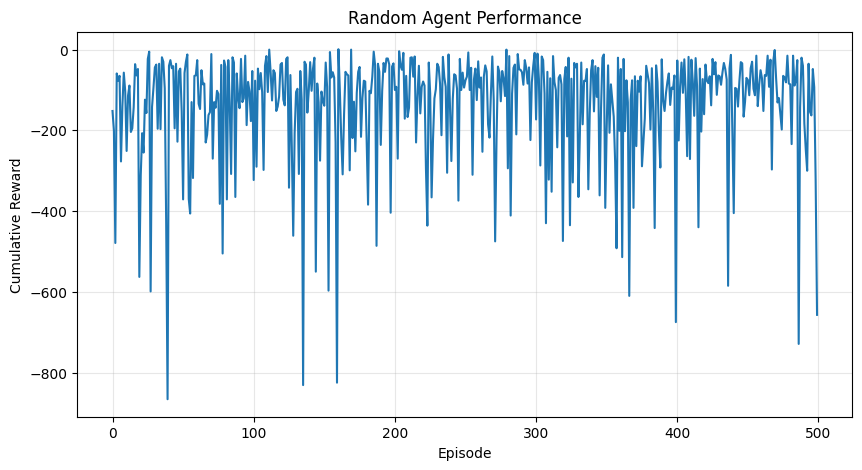

Average reward (Random Agent): -136.96


In [7]:
environment = GridWorld()
random_agent = RandomAgent()

reward_per_episode = play(environment, random_agent, trials=500)

# Simple learning curve
plt.figure(figsize=(10, 5))
plt.plot(reward_per_episode)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Random Agent Performance')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Average reward (Random Agent): {np.mean(reward_per_episode):.2f}")

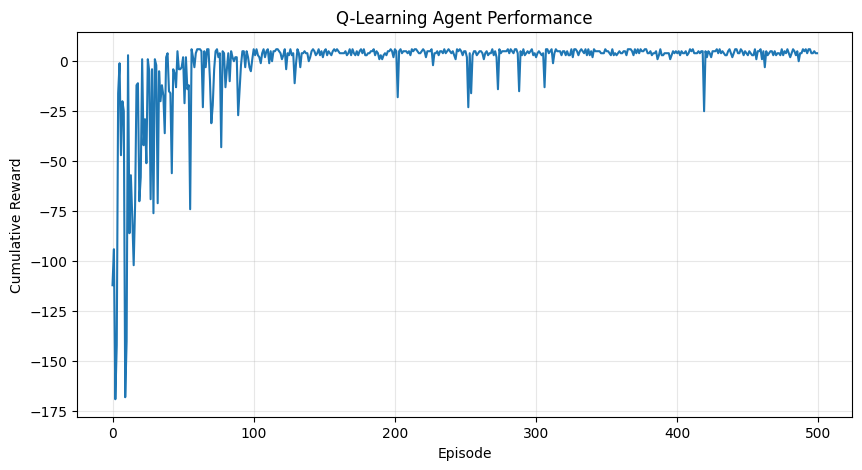

Average reward (Q-Learning Agent): -1.44


In [8]:
environment = GridWorld()
agentQ = Q_Agent(environment)

# Note the learn=True argument!
reward_per_episode = play(environment, agentQ, trials=500, learn=True)

# Simple learning curve
plt.figure(figsize=(10, 5))
plt.plot(reward_per_episode)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Q-Learning Agent Performance')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Average reward (Q-Learning Agent): {np.mean(reward_per_episode):.2f}")

In [9]:
#task 1

class DQN_Agent:
    def __init__(self, environment, epsilon=0.1, alpha=0.001, gamma=0.99,
                 batch_size=32, memory_size=2000):
        self.environment = environment
        self.epsilon = epsilon
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.batch_size = batch_size

        # Experience replay memory
        self.memory = deque(maxlen=memory_size)

        # Action mapping
        self.action_mapping = {'UP': 0, 'DOWN': 1, 'LEFT': 2, 'RIGHT': 3}
        self.action_list = ['UP', 'DOWN', 'LEFT', 'RIGHT']

        # State size (one-hot encoded position)
        self.state_size = environment.height * environment.width
        self.action_size = len(self.action_list)

        # Build neural network
        self.model = self._build_model()

    def _build_model(self):
        """Build a neural network to approximate Q-values"""
        model = keras.Sequential([
            layers.Dense(64, activation='relu', input_shape=(self.state_size,)),
            layers.Dense(64, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(self.action_size, activation='linear')
        ])
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=self.alpha),
                     loss='mse')
        return model

    def remember(self, state, action, reward, next_state, done):
        """Store experience in replay memory"""
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, available_actions):
        """Epsilon-greedy action selection (Task 2)"""
        if np.random.rand() < self.epsilon:
            # Exploration: random action
            return np.random.choice(available_actions)
        else:
            # Exploitation: best action based on Q-values
            state = self.environment.get_state_representation()
            state = np.reshape(state, [1, self.state_size])
            q_values = self.model.predict(state, verbose=0)[0]

            # Get Q-values for available actions only
            available_q = {action: q_values[self.action_mapping[action]]
                          for action in available_actions}
            return max(available_q, key=available_q.get)

    def replay(self):
        """Train the network using experience replay"""
        if len(self.memory) < self.batch_size:
            return

        # Sample random minibatch from memory
        minibatch = random.sample(self.memory, self.batch_size)

        states = np.array([experience[0] for experience in minibatch])
        actions = np.array([experience[1] for experience in minibatch])
        rewards = np.array([experience[2] for experience in minibatch])
        next_states = np.array([experience[3] for experience in minibatch])
        dones = np.array([experience[4] for experience in minibatch])

        # Predict Q-values for current states
        current_q = self.model.predict(states, verbose=0)

        # Predict Q-values for next states
        next_q = self.model.predict(next_states, verbose=0)

        # Update Q-values
        for i in range(self.batch_size):
            if dones[i]:
                current_q[i][actions[i]] = rewards[i]
            else:
                current_q[i][actions[i]] = rewards[i] + self.gamma * np.max(next_q[i])

        # Train the model
        self.model.fit(states, current_q, epochs=1, verbose=0)

print("DQN_Agent class defined!")

DQN_Agent class defined!


In [10]:
def play_dqn(environment, agent, trials=500, max_steps_per_episode=1000):
    """Play function for DQN agent"""
    reward_per_episode = []

    for trial in range(trials):
        cumulative_reward = 0
        step = 0
        game_over = False

        # Reset environment
        environment.__init__(height=environment.height, width=environment.width)

        while step < max_steps_per_episode and not game_over:
            # Get current state
            old_state = environment.get_state_representation()

            # Choose action
            action = agent.choose_action(environment.actions)
            action_idx = agent.action_mapping[action]

            # Take action
            reward = environment.make_step(action)
            new_state = environment.get_state_representation()

            # Check if terminal
            done = environment.check_state() == 'TERMINAL'

            # Store experience
            agent.remember(old_state, action_idx, reward, new_state, done)

            # Train the network
            agent.replay()

            cumulative_reward += reward
            step += 1

            if done:
                game_over = True

        reward_per_episode.append(cumulative_reward)

        # Print progress
        if (trial + 1) % 100 == 0:
            avg_reward = np.mean(reward_per_episode[-100:])
            print(f"Episode {trial + 1}/{trials}, Avg Reward (last 100): {avg_reward:.2f}")

    return reward_per_episode

In [11]:
print("Training DQN with epsilon = 0.1")
print("=" * 60)

env_dqn = GridWorld(height=8, width=8)
agent_dqn = DQN_Agent(env_dqn, epsilon=0.1, alpha=0.001, gamma=0.99)

rewards_dqn = play_dqn(env_dqn, agent_dqn, trials=500, max_steps_per_episode=1000)

# Plot results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(rewards_dqn, alpha=0.6)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('DQN Learning Curve (ε=0.1)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
window = 50
smoothed = np.convolve(rewards_dqn, np.ones(window)/window, mode='valid')
plt.plot(smoothed, linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Avg Cumulative Reward')
plt.title(f'DQN Learning Curve - Smoothed (window={window})')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nAverage reward (first 100 episodes): {np.mean(rewards_dqn[:100]):.2f}")
print(f"Average reward (last 100 episodes): {np.mean(rewards_dqn[-100:]):.2f}")


Training DQN with epsilon = 0.1


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Episode 100/500, Avg Reward (last 100): -17.21


KeyboardInterrupt: 

Training DQN with epsilon = 0.1 (FAST VERSION)
Optimizations: 200 episodes, batch_size=16, max_steps=500
------------------------------------------------------------
Episode 100/200, Avg Reward (last 100): -2.55
Episode 200/200, Avg Reward (last 100): 2.73


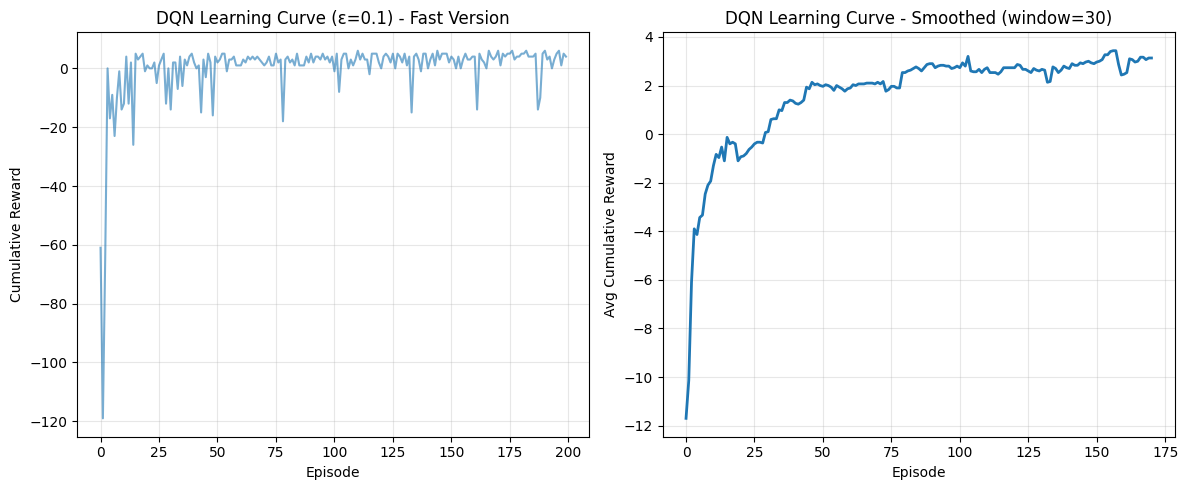


Average reward (first 50 episodes): -7.48
Average reward (last 50 episodes): 2.80
Improvement: 10.28


In [12]:
print("Training DQN with epsilon = 0.1 (FAST VERSION)")
print("=" * 60)
print("Optimizations: 200 episodes, batch_size=16, max_steps=500")
print("-" * 60)

env_dqn = GridWorld(height=8, width=8)
# Smaller batch size for faster training
agent_dqn = DQN_Agent(env_dqn, epsilon=0.1, alpha=0.001, gamma=0.99,
                      batch_size=16, memory_size=1000)

# Reduced trials: 200 instead of 500, reduced max_steps: 500 instead of 1000
rewards_dqn = play_dqn(env_dqn, agent_dqn, trials=200, max_steps_per_episode=500)

# Plot results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(rewards_dqn, alpha=0.6)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('DQN Learning Curve (ε=0.1) - Fast Version')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
window = 30  # Smaller window for fewer episodes
smoothed = np.convolve(rewards_dqn, np.ones(window)/window, mode='valid')
plt.plot(smoothed, linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Avg Cumulative Reward')
plt.title(f'DQN Learning Curve - Smoothed (window={window})')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nAverage reward (first 50 episodes): {np.mean(rewards_dqn[:50]):.2f}")
print(f"Average reward (last 50 episodes): {np.mean(rewards_dqn[-50:]):.2f}")
print(f"Improvement: {np.mean(rewards_dqn[-50:]) - np.mean(rewards_dqn[:50]):.2f}")

In [ ]:
print("\n" + "=" * 60)
print("TASK 2 & 3: Comparing DQN with Different Epsilon Values (FAST)")
print("=" * 60)
print("Optimizations: 200 episodes, batch_size=16, max_steps=500")
print("Estimated time: ~5-7 minutes")
print("=" * 60)

epsilon_values = [0.1, 0.5, 0.9]
results = {}

for epsilon in epsilon_values:
    print(f"\nTraining DQN with epsilon = {epsilon}")
    print("-" * 60)

    env = GridWorld(height=8, width=8)
    # Optimizations: smaller batch_size and memory_size
    agent = DQN_Agent(env, epsilon=epsilon, alpha=0.001, gamma=0.99,
                     batch_size=16, memory_size=1000)
    # Reduced trials and max_steps
    rewards = play_dqn(env, agent, trials=200, max_steps_per_episode=500)
    results[epsilon] = rewards

print("\nTraining completed for all epsilon values!")


TASK 2 & 3: Comparing DQN with Different Epsilon Values (FAST)
Optimizations: 200 episodes, batch_size=16, max_steps=500
Estimated time: ~5-7 minutes

Training DQN with epsilon = 0.1
------------------------------------------------------------
Episode 100/200, Avg Reward (last 100): -12.45
Episode 200/200, Avg Reward (last 100): 2.70

Training DQN with epsilon = 0.5
------------------------------------------------------------
